### 人工势场法轨迹规划


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from celluloid import Camera

### 定义输入类

In [2]:
# 本船参数
class OwnShip(object):
    def __init__(self, lo, la, v, h, ta, ts, tp, dt):
        self.lon = lo
        self.lat = la
        self.speed = v
        self.hdg = h
        self.turn_ang_tol = ta
        self.tn_s = ts
        self.tn_p = tp
        self.distance_tol = dt

    def update(self, new_lo, new_la, new_v, new_h):
        self.lon = new_lo
        self.lat = new_la
        self.speed = new_v
        self.hdg = new_h
    def move(self, delta_lo, delta_la):
        self.lon += delta_lo
        self.lat += delta_la
    def turn_to(self, new_h):
        self.hdg = new_h


class TargetShip(object):
    def __init__(self, m, lo, la, v, h, pr):
        self.m_msi = m
        self.lon = lo
        self.lat = la
        self.speed = v
        self.hdg = h
        self.potential_filed_l_range = pr


class Goal(object):
    def __init__(self, lo, la):
        self.lon = lo
        self.lat = la

### 初始参数设置

In [3]:

## 初始化的参数
d = 3.5  #航行区宽度

os = OwnShip(1, -d / 2, 1, math.atan(1.0), 1.0, 1.0, 1.0, 1.0) # 我船初始化

R = 0.5 # 我船安全半径

goal = Goal(9.5, d / 2) # 目的地初始化

# 障碍物初始化
obs_list = [TargetShip("000", 1.50, 7 / 4, 0.0, 0.0, 1.0),
            TargetShip("001", 3.00, -3 / 2, 0.0, 0.0, 1.5),
            TargetShip("010", 4.50, 3 / 2, 0.0, 0.0, 1.3),
            TargetShip("011", 6.00, -3 / 4, 0.0, 0.0, 0.9),
            TargetShip("100", 8.00, 3 / 2, 0.0, 0.0, 1.2)]

obs_num = len(obs_list)

Eta_att = 10 # 引力的增益系数

Eta_rep_ob = 50 # 斥力的增益系数

Eta_rep_edge = 200  # 道路边界斥力的增益系数

len_step = 0.03 # 步长

n = 1 # 计算斥力用的正常数

Num_iter = 300  # 最大循环迭代次数


### 数据存储变量定义


In [4]:
path = []  # 保存我船走过的每个点的坐标
hdg = [] # 经过计算给出的建议航向
delta = np.zeros((obs_num + 1,2)) # 保存我船当前位置与障碍物的方向向量，方向指向我船；以及保存我船当前位置与目标点的方向向量，方向指向目标点
dists = [] # 保存我船当前位置与障碍物的距离以及我船当前位置与目标点的距离
unite_vec = np.zeros((obs_num + 1,2)) #  保存我船当前位置与障碍物的单位方向向量，方向指向我船；以及保存我船当前位置与目标点的单位方向向量，方向指向目标点
F_rep_ob = np.zeros((obs_num + 1,2))  # 存储每一个障碍到我船的斥力,带方向

### 人工势场法实现

In [5]:
## ***************初始化结束，开始主体循环******************
def get_dis(x1, x2, y1, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

for i in range(Num_iter):
    if get_dis(os.lon, goal.lon, os.lat, goal.lat) < 1.0:
        break
    dists=[]
    path.append([os.lon, os.lat])
    #计算我船当前位置与障碍物的单位方向向量
    for j in range(obs_num):
        delta[j] = [os.lon - obs_list[j].lon, os.lat - obs_list[j].lat]
        dists.append(get_dis(os.lon, obs_list[j].lon, os.lat, obs_list[j].lat))
        unite_vec[j]=delta[j]/dists[j]
    #计算船只当前位置与目标的单位方向向量
    delta[-1] = [goal.lon - os.lon, goal.lat - os.lat]
    dists.append(get_dis(os.lon, goal.lon, os.lat, goal.lat))
    unite_vec[-1] = delta[-1]/dists[-1]

    ## 计算引力
    F_att = Eta_att*dists[-1]*unite_vec[-1]
    
    ## 计算斥力
    # 在原斥力势场函数增加目标调节因子（即我船至目标距离），以使我船到达目标点后斥力也为0
    for j in  range(obs_num):
        if dists[j] >= obs_list[j].potential_filed_l_range + R:
            F_rep_ob[j] = np.array([0, 0])
        else:
            d0 = obs_list[j].potential_filed_l_range+R
            # 障碍物的斥力1，方向由障碍物指向我船
            F_rep_ob1_abs = Eta_rep_ob * (1 / dists[j] - 1 / d0) * (dists[-1])**n / dists[j] ** 2  # 斥力大小
            F_rep_ob1 = F_rep_ob1_abs*unite_vec[j]  # 斥力向量
            # 障碍物的斥力2，方向由我船指向目标点，目的是在到达终点时合力为0，解决局部最优和目标不可达问题
            F_rep_ob2_abs = n/2 * Eta_rep_ob * (1 / dists[j] - 1 / d0) **2 *(dists[-1])**(n-1) # 斥力大小
            F_rep_ob2 = F_rep_ob2_abs * unite_vec[-1]  # 斥力向量
            # 改进后的障碍物合斥力计算
            F_rep_ob[j] = F_rep_ob1 + F_rep_ob2
    
    
    # 增加航线边界斥力势场，将我船约束在原定航线中
    F_rep_edge = 0
    if - d + R < os.lat <= - d / 2:
         F_rep_edge = [0, Eta_rep_edge * os.speed * np.exp(-d / 2 - os.lat)]  # 下道路边界区域斥力势场，方向指向y轴正向
    elif - d / 2 < os.lat <= - R / 2:
        F_rep_edge = np.array([0, 1 / 3 * Eta_rep_edge * os.lat ** 2])
    elif R / 2 < os.lat <= d / 2:
        F_rep_edge = np.array([0, - 1 / 3 * Eta_rep_edge * os.lat ** 2])
    elif d / 2 < os.lat <= d - R / 2:
        F_rep_edge = np.array([0, Eta_rep_edge * os.speed * (np.exp(os.lat - d / 2))])
    
    
    ## 计算合力和方向
    F_rep = np.sum(F_rep_ob, axis=0)+F_rep_edge
    
    F_sum = F_att+F_rep
    
    UnitVec_Fsum = 1 / np.linalg.norm(F_sum) * F_sum
    #计算我船的下一步位置
    tmp = os.speed * len_step * UnitVec_Fsum
    os.move(tmp[0], tmp[1])
    new_h = math.degrees(math.atan2(UnitVec_Fsum[1],UnitVec_Fsum[0]))
    print("建议航向：", new_h, "°")
    hdg.append(new_h)
    os.turn_to(new_h)

path.append([goal.lon,goal.lat]) # 最后把目标点也添加进路径中
path=np.array(path) # 转为numpy

建议航向： 70.11483488614456 °
建议航向： 69.92868631430973 °
建议航向： 69.47390589218261 °
建议航向： 69.02169981203726 °
建议航向： 68.55936938978242 °
建议航向： 68.08688563808222 °
建议航向： 67.60424716579526 °
建议航向： 67.1114832802194 °
建议航向： 66.60865720347984 °
建议航向： 66.0958693684619 °
建议航向： 65.573260750413 °
建议航向： 65.04101618017123 °
建议航向： 64.49936757406955 °
建议航向： 63.948597004144645 °
建议航向： 63.38903952066318 °
建议航向： 62.82108562758257 °
建议航向： 62.24518330090577 °
建议航向： 61.66183943059442 °
建议航向： 61.07162055949388 °
建议航向： 60.475152788402184 °
建议航向： 59.873120715847314 °
建议航向： 59.266265285212874 °
建议航向： 58.65538042143522 °
建议航向： 58.04130835537214 °
建议航向： 57.42493355675292 °
建议航向： 56.80717522678243 °
建议航向： 56.18897833911192 °
建议航向： 55.57130326276454 °
建议航向： 54.95511405203111 °
建议航向： 54.34136554516431 °
建议航向： 53.730989474195866 °
建议航向： 53.12487985014819 °
建议航向： 52.523877948551046 °
建议航向： 51.92875727628886 °
建议航向： 51.34020894880724 °
建议航向： 50.75882794280364 °
建议航向： 50.18510070990147 °
建议航向： 49.619394637895546 °
建议航向： 49.

### 画图

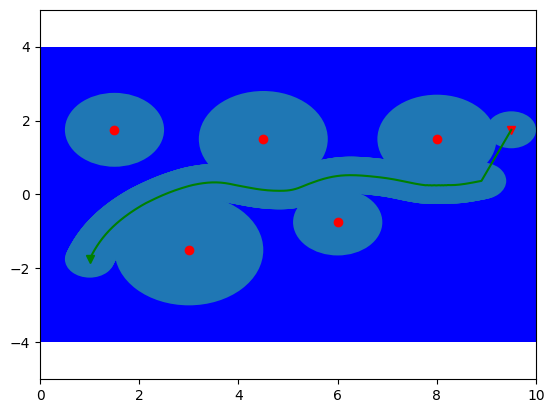

In [6]:
# ## 画图
fig=plt.figure(1)

plt.axis([0,10,-5,5])
len_line = 100
# 画灰色路面图
GreyZone = np.array([[- 5, - d - 0.5], [- 5, d + 0.5],
            [len_line, d + 0.5], [len_line, - d - 0.5]])
plt.fill(GreyZone[:, 0], GreyZone[:, 1], 'blue')
for j in range(obs_num):
    plt.plot(obs_list[j].lon,obs_list[j].lat, 'ro') #障碍物位置
    circle = plt.Circle((obs_list[j].lon,obs_list[j].lat),obs_list[j].potential_filed_l_range)
    plt.gcf().gca().add_artist(circle)
for i in range(len(path)):
    circle = plt.Circle((path[i,0],path[i,1]),R)
    plt.gcf().gca().add_artist(circle)
plt.plot(goal.lon,goal.lat, 'rv')  # 目标位置
plt.plot(path[0,0],path[0,1], 'gv')
plt.plot(path[1:len(path),0],path[1:len(path),1], 'g')  # 路径点
plt.show()
